# Import Dataset Dari Kaggle

In [ ]:
#Menginstall package kaggle agar bisa mengimport dataset
!pip install -q kaggle

In [ ]:
#Melakukan import pada library yang dibutuhkan nantinya
import nltk
import numpy as np
import pandas as pd
import keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
from keras.callbacks import EarlyStopping
from keras.preprocessing import text, sequence
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Gunakan file.upload() untuk mengimport kaggle.json(akun kaggle) agar bisa melakukan API kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varenzowie","key":"c3008a5e87b883ba27775cd6d5071f74"}'}

In [ ]:
#Melakukan pembuatan direktori dan mengubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
#download dataset
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 94.9MB/s]


In [ ]:
# unzip dan lihat list isi dataset
!emotions-dataset-for-nlp
!unzip emotions-dataset-for-nlp.zip -d emotions-dataset-for-nlp
!ls emotions-dataset-for-nlp

/bin/bash: line 1: emotions-dataset-for-nlp: command not found
Archive:  emotions-dataset-for-nlp.zip
  inflating: emotions-dataset-for-nlp/test.txt  
  inflating: emotions-dataset-for-nlp/train.txt  
  inflating: emotions-dataset-for-nlp/val.txt  
test.txt  train.txt  val.txt


In [ ]:
# Membaca data dari 3 file yang ada di dataset
df1 = pd.read_csv('emotions-dataset-for-nlp/test.txt', sep=';', names=['Text', 'Emotion'])
df2 = pd.read_csv('emotions-dataset-for-nlp/train.txt', sep=';', names=['Text', 'Emotion'])
df3 = pd.read_csv('emotions-dataset-for-nlp/val.txt', sep=';', names=['Text', 'Emotion'])

# Menggabungkan ketiga file.
df = pd.concat([df1, df2, df3], ignore_index=True)

# Menyimpan data yang awalnya berupa txt menjadi csv
df.to_csv('data.csv', index=False)

# Pengecekan data terhadap 20 data teratas
df.head(20)


,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
5,i cant walk into a shop anywhere where i do no...,fear
6,i felt anger when at the end of a telephone call,anger
7,i explain why i clung to a relationship with a...,joy
8,i like to have the same breathless feeling as ...,joy
9,i jest i feel grumpy tired and pre menstrual w...,anger


# Data Cleaning (Pembersihan Data)

## Pengecekan Data

In [ ]:
#Melihat banyak data, tipe data, serta apakah ada keanehan pada data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     20000 non-null  object
 1   Emotion  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [ ]:
# Melihat banyaknya missing value pada data
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
# Melakukan Drop pada missing value.
# Disini data sudah tidak ada missing value,
# Tapi saya tetap memberikan kode agar menjadi pembelajaran bagi saya kedepannya
df=df.dropna()

In [ ]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
# Melihat value dari data dari kolom Emotion.
df.Emotion.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotion, dtype: int64

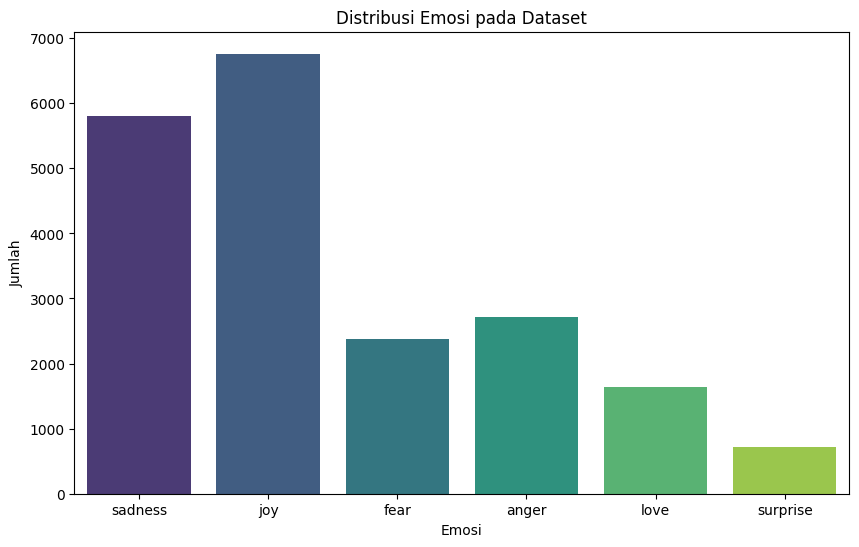

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=df, palette='viridis')

# Menambahkan judul dan label sumbu
plt.title('Distribusi Emosi pada Dataset')
plt.xlabel('Emosi')
plt.ylabel('Jumlah')

# Menampilkan diagram batang
plt.show()

## Proses Pembersihan Data

In [ ]:
#Melakukan pembersihan pada Stopword
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

In [ ]:
#Melakukan Pemberi
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#hapus square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#hapus URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)
#hapus stopwords dari text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct

#hapus noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

#Melakukan implementasi dari semua fungsi pembersihan di atas
df['Text']=df['Text'].apply(denoise_text)

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.Text)
corpus[:10]

['im',
 'feeling',
 'rather',
 'rotten',
 'im',
 'ambitious',
 'right',
 'im',
 'updating',
 'blog']

In [ ]:
#jumlah kata yang sering ditemukan
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'feel': 13938,
 'feeling': 6431,
 'like': 3616,
 'im': 3055,
 'really': 1182,
 'know': 1080,
 'time': 993,
 'little': 932,
 'get': 926,
 'people': 839}

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Data Transformation dan Melakkukan Splitting Data

In [ ]:
# Membuat dummies untuk df_baru menggunakan one-hot-encoding
emotion = pd.get_dummies(df.Emotion)
column_order = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
df_baru = pd.concat([df, emotion], axis=1)
df_baru = df_baru[['Text'] + column_order]
df_baru

,Text,joy,sadness,anger,fear,love,surprise
0,im feeling rather rotten im ambitious right,0,1,0,0,0,0
1,im updating blog feel shitty,0,1,0,0,0,0
2,never make separate ever want feel like ashamed,0,1,0,0,0,0
3,left bouquet red yellow tulips arm feeling sli...,1,0,0,0,0,0
4,feeling little vain one,0,1,0,0,0,0
...,...,...,...,...,...,...,...
19995,im ssa examination tomorrow morning im quite w...,0,1,0,0,0,0
19996,constantly worry fight nature push limits inne...,1,0,0,0,0,0
19997,feel important share info experience thing,1,0,0,0,0,0
19998,truly feel passionate enough something stay tr...,1,0,0,0,0,0


In [ ]:
#Membagi data menjadi 2 macam
text = df_baru['Text'].values
label = df_baru[['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']].values

In [ ]:
#text berisi data kalimat yang diketik pengguna
text

array(['im feeling rather rotten im ambitious right',
       'im updating blog feel shitty',
       'never make separate ever want feel like ashamed', ...,
       'feel important share info experience thing',
       'truly feel passionate enough something stay true succeed',
       'feel like wanna buy cute make see online even one'], dtype=object)

In [ ]:
#label berisi data binary dari kolom Emotions
label

array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
#Melakukan training data
x_train,x_test,y_train,y_test = train_test_split(text, label,test_size = 0.2,shuffle=True)

In [ ]:
#Melakukan Tokenizer pada data
tokenizer = Tokenizer(num_words=10000, oov_token='<oov>')
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=200, truncating='post')
pad_test = pad_sequences(sequences_test, maxlen=200, truncating='post')

print(pad_test.shape)
print(pad_train.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 200)
(16000, 200)
(16000, 6)
(4000, 6)


In [ ]:
pad_train

array([[   0,    0,    0, ...,    3, 7216,  442],
       [   0,    0,    0, ...,  219,    2,  666],
       [   0,    0,    0, ...,  995,  198, 1474],
       ...,
       [   0,    0,    0, ...,    1,  266,    1],
       [   0,    0,    0, ...,   19,    1,   29],
       [   0,    0,    0, ...,  359,   27, 1563]], dtype=int32)

In [ ]:
pad_test

array([[   0,    0,    0, ...,   84,  128, 6390],
       [   0,    0,    0, ...,  445,  685,    1],
       [   0,    0,    0, ...,    2,  647,    1],
       ...,
       [   0,    0,    0, ...,  213,    3,  262],
       [   0,    0,    0, ...,  225,  268,   19],
       [   0,    0,    0, ...,    2,  559,  271]], dtype=int32)

# Modelling

In [ ]:
# Pembuatan Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=200),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 756102 (2.88 MB)
Trainable params: 756102 (2.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91 and logs.get('val_accuracy')>0.91):
      self.model.stop_training = True
      print("Akurasi sudah mencapai 91%")
callbacks = myCallback()

# Testing

In [ ]:
num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs,
                    validation_data=(pad_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
500/500 - 141s - loss: 1.1417 - accuracy: 0.5352 - val_loss: 0.5165 - val_accuracy: 0.8338 - 141s/epoch - 283ms/step
Epoch 2/50
500/500 - 140s - loss: 0.2937 - accuracy: 0.9045 - val_loss: 0.2687 - val_accuracy: 0.9057 - 140s/epoch - 281ms/step
Epoch 3/50
500/500 - 144s - loss: 0.1321 - accuracy: 0.9539 - val_loss: 0.2625 - val_accuracy: 0.9035 - 144s/epoch - 287ms/step
Epoch 4/50
500/500 - 128s - loss: 0.0799 - accuracy: 0.9731 - val_loss: 0.2974 - val_accuracy: 0.8990 - 128s/epoch - 257ms/step
Epoch 5/50
500/500 - 143s - loss: 0.0586 - accuracy: 0.9799 - val_loss: 0.3011 - val_accuracy: 0.9018 - 143s/epoch - 287ms/step
Epoch 6/50
Akurasi sudah mencapai 91%
500/500 - 131s - loss: 0.0498 - accuracy: 0.9827 - val_loss: 0.3339 - val_accuracy: 0.9110 - 131s/epoch - 261ms/step


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

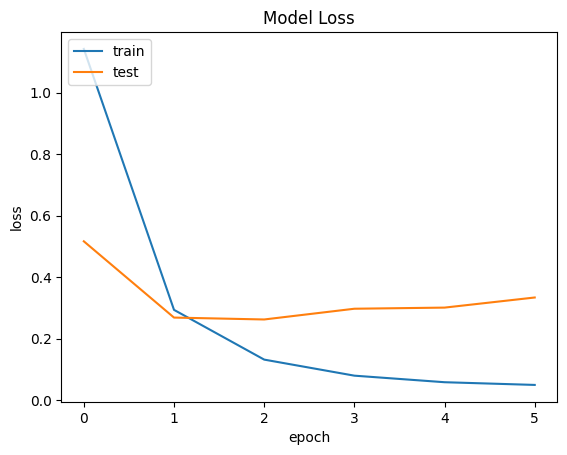

In [ ]:
#Membuat plot loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

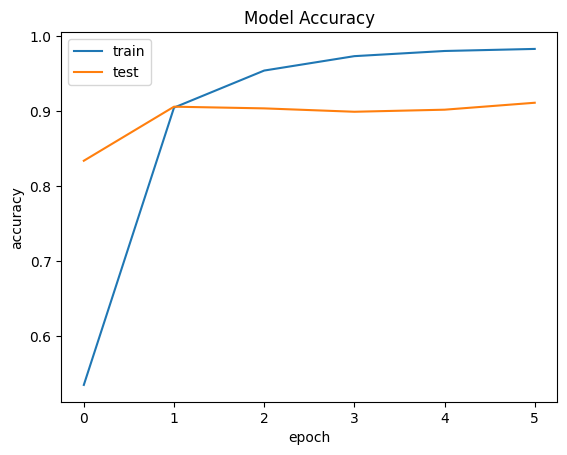

In [ ]:
#Membuat Plot Accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()